# Model Specification

The model (Polyn, Norman & Kahana, 2009) combines:

- **Episodic associations**: Learned connections between items and the temporal context in which they were presented
- **Semantic associations**: Pre-existing associations between items based on their meaning
- **Context drift**: gradual change in mental context over time during encoding and retrieval

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

## Retrieval weights

These parameters control the relative strength of semantic versus episodic retrieval routes:

1. **sem**: Weight of semantic associations (meaning-based connections)
2. **episodic**: Weight of episodic associations (temporal context-based connections)

- Weights are normalized so they sum to 1, determining the relative contribution of each route during memory retrieval. 
- Equal weights (0.5/0.5) mean both routes contribute equally to recall.

In [2]:
# strength of drift
# scale_drift = 0.4  # scaling parameter (not used if inputting manual drift)

# strength of semantic + episodic route
sem = 0.5
episodic = 0.5

# normalize
sem_weight = sem / (episodic + sem)
episodic_weight = episodic / (episodic + sem)

## Reward Sequence

Defines the presentation order and values of items in the simulated memory list:

- **pres_indices**: Random permutation determining the order items are presented
- **sequence**: Reward values associated with each position (used to calculate prediction errors)

The "primacy" sequence used here shows gradually decreasing values (54 → 45), which can affect context drift when prediction error-based drift is enabled. This simulates scenarios where reward or value changes over the course of a sequence.

In [3]:
# random sample (1-indexed to match R behavior, then convert to 0-indexed)
pres_indices = np.random.permutation(10) + 1

# high RPE within sequence
# sequence = np.array([0, 54, 57, 56, 53, 55, 7, 5, 4, 6, 3])  # initial expectation is 0

# primacy (first outcome is "reward expectation" at 50)
sequence = np.array([50, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45])

## Context Integration Rates (β)

### Dynamic drift based on PE
1. Calculate absolute prediction errors (difference between consecutive rewards)
2. Z-score normalize the prediction errors
3. Scale by `scale_drift` parameter
4. Cap maximum drift at 1.0

> Larger prediction errors cause greater context drift. This enhances memory for items around surprising events.

In [4]:
# dynamic beta
# absPE = np.zeros((len(pres_indices), 1))

# take absolute difference of previous reward with current reward
# (first "prediction error" is reward - initial expectation)
# for seq in range(len(sequence) - 1):
#     absPE[seq] = abs(sequence[seq] - sequence[seq + 1])

# take absolute value of z-scored absPE and multiply by scaling parameter
# B_encD = np.abs(zscore(absPE)) * scale_drift

# B_encD = np.where(B_encD > 1, 1, B_encD)  # if it's over 1, make it 1

### Hardcoded drift for each item during encoding:

- **B_encD[0] = 1.0**: First item causes maximum context drift (complete context update)
- **B_encD[1:] = 0.65**: Subsequent items cause moderate drift

In [5]:
# manual drift (comment out if using modulated or stable drift)
B_encD = np.array([1, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65])

## Semantic Matrix

Defines pre-existing semantic associations between items:

- **Identity matrix structure**: Each item has activation of 1.0 to itself, 0 to all others
- This represents **orthogonal** items with no semantic similarity

**Interpretation**: In this simple version, items have no inherent semantic relationships. The semantic route will primarily help retrieve items based on their direct activation rather than meaning-based associations. For more realistic simulations, this could be replaced with a structured similarity matrix based on word associations, categories, etc.

In [6]:
# create "semantic" matrix
# each item has an activation of 1 (and to no other units)
sem_mat = np.eye(len(pres_indices))

## Parameters calibrated to human free recall data

### Network Architecture
- **gamma_fc (0.581)**: Strength of pre-existing feature-context associations
- **eye_fc, eye_cf**: Initialize connection matrices

### Encoding Parameters
- **B_enc (0.745)**: Standard context integration rate during study
- **lrate_fc_enc**: Learning rate for feature→context connections
- **lrate_cf_enc**: Learning rate for context→feature connections

### Retrieval Parameters
- **B_rec (0.36)**: Context integration during recall (slower than encoding)
- **lrate_fc_rec, lrate_cf_rec (0)**: No new learning during recall

### Decision Competition
- **thresh (1)**: Activation threshold for successful recall
- **L (0.375)**: Lateral inhibition between competing items
- **K (0.091)**: Decay rate of accumulator activation
- **eta (0.3699)**: Noise in the decision process
- **tau (413 ms)**: Time constant for accumulation

These parameters create a competitive retrieval process where items race to threshold, with noise and inhibition producing realistic recall dynamics.

In [7]:
gamma_fc = 0.581  # relative strength of pre-existing associations on connections feature-context
eye_fc = 1 - gamma_fc  # if items are rep as orthonormal vectors, identity matrix ("eye")
eye_cf = 0

# during encoding
B_enc = 0.745  # vector of context integration rate at encoding (dynamic alternative above)
lrate_fc_enc = gamma_fc  # feature-to-context during encoding
lrate_cf_enc = 1  # context-to-feature during encoding

# during recall
B_rec = 0.36  # vector of context integration at recall
lrate_fc_rec = 0  # feature-to-context during recall
lrate_cf_rec = 0  # context-to-feature during recall
thresh = 1  # threshold for an accumulating element to win
rec_time = 90000  # max recall process (90 seconds)
dt = 100  # time constant on decision process
L = 0.375  # lateral inhibition between units
K = 0.091  # decay rate for the accumulating element
eta = 0.3699  # standard deviation of gaussian noise term in decision competition
tau = 413  # time constant in decision competition

n_sims = 1000  
recall_sims = np.zeros((len(pres_indices), n_sims))
times_sims = np.zeros((len(pres_indices), n_sims))

# Model Run

Main simulation loop implementing the CMR model's encoding and retrieval phases.

### Overall Logic
For each simulation:
1. **Initialize network**: Create feature and context layers, connection weights
2. **Encoding phase**: Present items sequentially, update context and associations
3. **Retrieval phase**: Use context cues to retrieve items via competitive accumulation

### Encoding Phase
For each presented item:
1. Activate the item's feature representation
2. Calculate context input from feature layer (via learned associations)
3. Update context using drift equation: `c_new = ρ·c_old + β·c_in`
   - **ρ (rho)**: Ensures context vector stays normalized
   - **β (beta)**: Controls integration rate (how much context changes)
4. Learn associations between active features and current context

So **two** “jobs” happening with each new item:
1. Update the state (context vector c)
2. Update the memory traces (associative matrices $M^{FC}$, $M^{CF}$)

### Retrieval Phase
Iterative process until time runs out:
1. Use current context to activate features (via episodic + semantic routes)
2. Run accumulator race:
   1) Each item accumulates activation based on its cue strength
   2) Lateral inhibition suppresses competitors
      - Every item inhibits every other item by strength L, but does not inhibit itself.
   3) Noise creates variability
      - Each item’s evidence accumulator jitters randomly at each timestep.
   4) Decay prevents runaway activation
      - All accumulators leak at the same rate K
3. When an item crosses threshold:
   - Record the recall
   - Mark item as retrieved & prevent repetitions:
      - Step 1: find items that are already retrieved and have accumulator level above threshold
      - Step 2: push them under threshold by setting them to 0.95 * threshold
	   - Already recalled items remain almost winning but will not trigger another recall
   - Use retrieved item to update context
   - Continue with new context state

> Each recall changes context, which determines what gets recalled next (temporal contiguity effect)

In [8]:
for sims in range(n_sims):
    
    # initialize features and context layers
    net_f = np.zeros((len(pres_indices), 1)) # when item i is presented, set net_f[i]=1
    net_c = np.zeros((len(pres_indices), 1)) 
    
    # learning rate matrices
    net_lrate_fc = np.zeros((len(pres_indices), len(pres_indices))) # N×N zeros
    net_lrate_cf = np.zeros((len(pres_indices), len(pres_indices))) # N×N zeros
    # These are meant to be overwritten by the active learning-rate matrix 
    # e.g., during encoding set to net_lrate_fc_enc, during recall set to net_lrate_fc_rec
    # So these are placeholder variables, not true parameters.
   
    net_lrate_fc_enc = np.full((len(pres_indices), len(pres_indices)), lrate_fc_enc) # N×N filled with lrate_fc_enc
    net_lrate_cf_enc = np.full((len(pres_indices), len(pres_indices)), lrate_cf_enc) # N×N filled with lrate_cf_enc
    net_lrate_fc_rec = np.full((len(pres_indices), len(pres_indices)), lrate_fc_rec) # N×N filled with lrate_fc_rec
    net_lrate_cf_rec = np.full((len(pres_indices), len(pres_indices)), lrate_cf_rec) # N×N filled with lrate_cf_rec
    # Because learning rates are constant everywhere, these matrices are functionally equivalent to scalars
    
    # associative weight matrices
    net_w_fc = np.eye(len(net_c)) * eye_fc  # eye() creates identity matrices
    net_w_cf = np.eye(len(net_f)) * eye_cf  
    net_weights = np.zeros((len(pres_indices), len(pres_indices))) # placeholder variable
    
    # ––––––––––––––––––––––– ENCODING –––––––––––––––––––––––

    net_idx = np.arange(len(pres_indices))
    
    for item in range(len(pres_indices)):
        
        # present item
        feature_idx = pres_indices[item] - 1  # Convert to 0-indexed
        
        # activates the indexed feature (each item activates one element)
        net_f = np.zeros((len(pres_indices), 1))
        net_f[feature_idx] = 1
        
        # –––––––––––––––––– Update state ––––––––––––––––––
        # update context representations
        net_c_in = net_w_fc @ net_f
        
        # normalize vector
        vec = net_c_in
        denom_vec = np.sqrt(vec.T @ vec)[0, 0]
        norm_vec = vec / denom_vec
        net_c_in = norm_vec
        
        # advance context
        c_in = net_c_in
        c = net_c
        
        # set dynamic or stable drift
        B = B_encD[item]  # beta at encoding for dynamic
        # B = B_enc  # beta at encoding if stable
        
        dot_product = (c.T @ c_in)[0, 0]
        rho = np.sqrt(1 + (B**2) * ((dot_product**2) - 1)) - B * dot_product
        updated_c = rho * c + B * c_in
        net_c = updated_c
        
        # ––––––––– Update memory traces –––––––––––
        # determine current learning rate
        lrate_fc = net_lrate_fc_enc
        lrate_cf = net_lrate_cf_enc
        
        # update weights
        # w_fc
        delta = (net_c @ net_f.T) * lrate_fc
        net_w_fc = net_w_fc + delta
        # w_cf
        delta = (net_f @ net_c.T) * lrate_cf
        net_w_cf = net_w_cf + delta
    
    # ––––––––––––––––––––––––– RECALL ––––––––––––––––––––––––––––
    
    # set up
    recalls = np.zeros((len(pres_indices), 1))
    times = np.zeros((len(pres_indices), 1))
    
    rec_time_local = 90000
    time_passed = 0
    recall_count = 0
    
    retrieved = np.zeros((len(pres_indices), 1), dtype=bool)
    thresholds = np.ones((len(pres_indices), 1))
    
    # semantic + episodic routes
    net_weights = episodic_weight * net_w_cf + sem_weight * sem_mat
    
    # –––––––––––––––––––– GO!!! ––––––––––––––––––––
    
    while time_passed < rec_time_local:
        
        # input to the feature layer, from last context cue
        f_in = net_weights @ net_c
        
        # set max number of cycles
        max_cycles = int((rec_time_local - time_passed) / dt)
        
        # Noise error standard deviation
        dt_tau = dt / tau
        sq_dt_tau = np.sqrt(dt_tau) # noise scales with √time in diffusion processes
        
        # Pre-generate all noise for the whole recall period (matrix of Gaussian noise)
        noise = np.random.normal(0, eta * sq_dt_tau, (len(pres_indices), max_cycles))
        
        # Build lateral inhibition matrix
        eyeI = ~np.eye(len(pres_indices), dtype=bool) # True off-diagonal, False on diagonal
        lmat = eyeI.astype(float) * L
        
        # Utility variables for looping
        ncycles = noise.shape[1]
        inds = np.arange(len(pres_indices))
        
        # Track whether any item has hit threshold yet
        crossed = 0
        
        # Initialize accumulator activations for all items
        x = np.zeros((len(pres_indices), 1))
        
        # Expand the leak parameter to match dimensionality
        K_array = np.ones((len(pres_indices), 1)) * K
        
        # Start cycle counter
        i = 0
        
        # –––––––––––––– ACCUMULATORS CYCLING –––––––––––––––
        while i < ncycles and crossed == 0:
            
            # lateral inhibition felt by each unit
            lx = lmat @ x
            
            # leaking from each unit
            kx = K_array * x
            
            # change in each accumulator
            x = x + ((f_in - kx - lx) * dt_tau + noise[:, i:i+1])
            x[x < 0] = 0
            
            # reset retrieved values, allow them to compete but prevent from accumulating
            reset_these = retrieved & (x >= thresholds)
            x[reset_these] = 0.95 * thresholds[reset_these]
            
            # retrieved items cannot be repeated
            retrievable = ~retrieved
            
            # determine whether any items have crossed thresholds
            crossed = 0
            if np.any(x[retrievable] >= thresholds[retrievable]):
                crossed = 1
                temp_win = x[retrievable] >= thresholds[retrievable]
                temp_ind = inds[retrievable.flatten()]
                winners = temp_ind[temp_win.flatten()]
                
                # if there is a tie, random tiebreak
                if len(winners) > 1:
                    winners = np.array([np.random.choice(winners)])
                
                winner_position = np.where(pres_indices - 1 == winners[0])[0][0]
            
            i = i + 1
        
        # calculate the amount of elapsed time
        time = i * dt
        time_passed = time_passed + time
        
        # reactivate item if there has been a retrieval
        if crossed == 1:
            
            # activate the retrieved feature
            net_f = np.zeros((len(pres_indices), 1))
            net_f[winners[0]] = 1
            
            # update context representations
            net_c_in = net_w_fc @ net_f
            
            # normalize vector
            vec = net_c_in
            denom_vec = np.sqrt(vec.T @ vec)[0, 0]
            norm_vec = vec / denom_vec
            net_c_in = norm_vec
            
            # advance context
            c_in = net_c_in
            c = net_c
            B = B_rec  # beta at retrieval
            
            dot_product = (c.T @ c_in)[0, 0]
            rho = np.sqrt(1 + (B**2) * ((dot_product**2) - 1)) - B * dot_product
            updated_c = rho * c + B * c_in
            net_c = updated_c
            
            # determine current learning rate
            lrate_fc = net_lrate_fc_rec
            lrate_cf = net_lrate_cf_rec
            
            # w_fc
            delta = (net_c @ net_f.T) * lrate_fc
            net_w_fc = net_w_fc + delta
            
            # w_cf
            delta = (net_f @ net_c.T) * lrate_cf
            net_w_cf = net_w_cf + delta
            
            # record data
            recall_count = recall_count + 1
            recalls[recall_count - 1, 0] = winner_position + 1  # Convert back to 1-indexed
            times[recall_count - 1, 0] = time_passed
            
            # update retrieved vector
            retrieved[winners[0]] = True
    
    recall_sims[:, sims] = recalls.flatten()
    times_sims[:, sims] = times.flatten()

print(f"Model run complete. Simulated {n_sims} trials.")

Model run complete. Simulated 1000 trials.


> `recall_sims` is a matrix shaped like:
 $(\text{recall output index}) \times (\text{simulation number})$

## Serial Position Curve

Analyzes recall probability as a function of an item's position in the study list.

### Calculation Logic
For each serial position (1-10):
- Count how many times items from that position were recalled across all simulations
- Divide by total number of simulations to get recall probability

### Expected Pattern
- **Primacy effect**: Higher recall for early items (positions 1-3)
  - In full CMR2, primacy is implemented with a primacy gradient $(ϕ_s, ϕ_d)$. This notebook does not include that.
- **Recency effect**: Higher recall for recent items (positions 8-10)
  - Emergent from the fact recall starts with the last context state
  - Caused by end-of-list context still being active during recall

In [9]:
# create a column [1..N] just for labeling
position = pd.DataFrame({'position': np.arange(1, len(pres_indices) + 1)})

# create an array of length N to store counts
numSums = np.zeros(len(pres_indices))

for numSum in range(len(numSums)):
    numSums[numSum] = np.sum(recall_sims == (numSum + 1))
    # recall_sims: boolean matrix storing serial positions (1..N) for each recall event
    # True wherever that serial position was recalled
    # count how many True across the whole matrix

recall = numSums / n_sims

prop_recall = pd.DataFrame({
    'position': position['position'],
    'recall': recall
})

print(prop_recall)

   position  recall
0         1   0.098
1         2   0.099
2         3   0.157
3         4   0.279
4         5   0.450
5         6   0.684
6         7   0.879
7         8   0.988
8         9   0.995
9        10   1.000


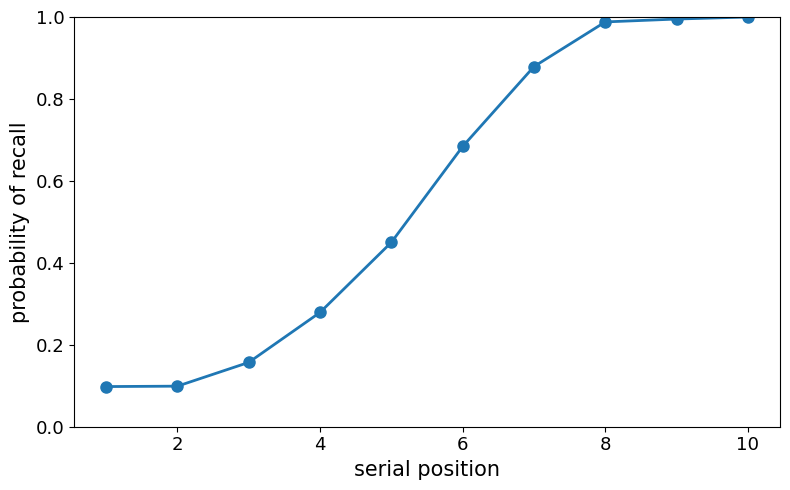

In [10]:
plt.figure(figsize=(8, 5))
plt.plot(prop_recall['position'], prop_recall['recall'], 'o-', linewidth=2, markersize=8)
plt.xlabel('serial position', fontsize=15)
plt.ylabel('probability of recall', fontsize=15)
plt.ylim(0, 1)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(False)
plt.tight_layout()
plt.show()

- Roughly constant encoding drift (mostly $B \approx 0.65$) makes similarity between each item’s context and the end-of-list context decrease monotonically with distance (earlier serial positions are less similar). 
    - This creates a monotonic gradient in initial retrieval cue strength, though not necessarily a monotonic curve in recall probability. 
- The S-shaped recall probability emerges from the recall stage: a noisy, competitive accumulator with thresholding and finite time

## First Recall Probability

Analyzes which items are most likely to be recalled first when retrieval begins.

### Calculation Logic
- Extract the first recalled item from each simulation
- Count frequency of each position being recalled first
- Convert to proportions
    - proportion of all simulations (including nothing-recalled cases)

### Theoretical Predictions
First recall is strongly influenced by:
1. **Recency**: Recent items have highest context match with end-of-list state
2. **Primacy**: With high initial drift, first item may have unique retrieval advantage
3. **Semantic strength**: Items with strong semantic cues may be recalled first

In [11]:
# each number is a serial position of the first recalled item in that simulation
first_recall = recall_sims[0, :] 
# filter out zeros (remove nothing recalled cases)
first_recall = first_recall[first_recall > 0] 

# create frequency table for:
# A: sorted list of distinct serial positions observed
# B: how many times each appeared
unique, counts = np.unique(first_recall, return_counts=True)
first_recall_table = pd.DataFrame({
    'position': unique.astype(int),
    'freq': counts,
    'prop': counts / n_sims
})

print(first_recall_table)

   position  freq   prop
0         1     2  0.002
1         2     3  0.003
2         3     5  0.005
3         4     1  0.001
4         5     4  0.004
5         6    14  0.014
6         7    22  0.022
7         8    78  0.078
8         9   222  0.222
9        10   649  0.649


In free recall, the last few items dominate first recalls due to context matching.

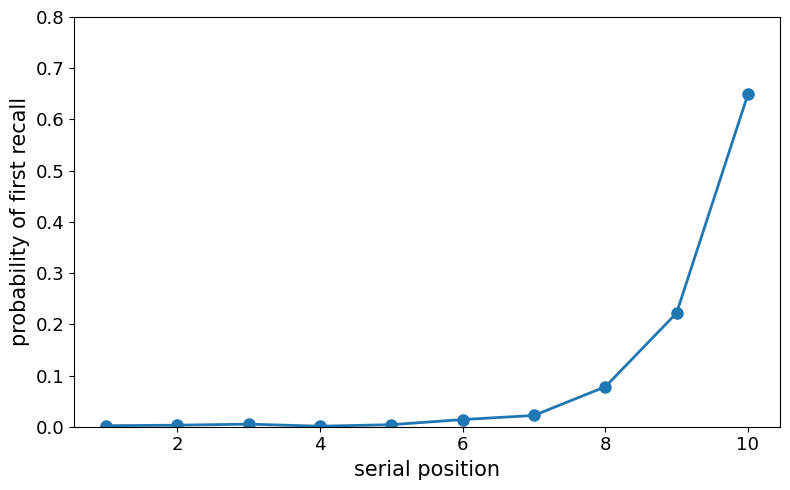

In [12]:
plt.figure(figsize=(8, 5))
plt.plot(first_recall_table['position'], first_recall_table['prop'], 'o-', linewidth=2, markersize=8)
plt.xlabel('serial position', fontsize=15)
plt.ylabel('probability of first recall', fontsize=15)
plt.ylim(0, 0.8)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(False)
plt.tight_layout()
plt.show()

## Conditional Response Probabilities (CRP)

Analyzes **temporal contiguity effect**: tendency to recall items that were studied near each other in time.

### Calculation Logic

#### 1. Observed (Actual) Transitions
For each recall sequence, compute the lag between consecutive recalls:
$$\text{lag} = (\text{next serial position}) - (\text{current serial position})$$
- E.g.: $5 \rightarrow 7$ gives lag $+2$; $8 \rightarrow 6$ gives lag $-2$

#### 2. Available (Possible) Transitions
At each recall step, determine what *could* be recalled next:
- Remove items that have already been recalled
- From the current position $i$, compute all possible lags to the remaining items:
$$\{j - i : j \in \text{unrecalled items}\}$$

#### 3. Conditional Response Probability (CRP)
For each lag value $L$, compute:
$$\text{CRP}(L) = \dfrac{\#\{\text{observed transitions with lag } L\}}{\#\{\text{times lag } L \text{ was available}\}}$$

> After recalling item $i$, *given the remaining unrecalled items*, how likely is the next recall to be at lag $L$?

### Why CRP must be conditional
If only count observed lags (*unconditional* lag), the curve is biased by **where recall starts**.

- E.g.: Recall often starts near the end of the list (recency): $10 \rightarrow 9 \rightarrow 8 \rightarrow 7 \rightarrow \dots$. This produces many lags of $-1$

So an unconditional lag count may show a larger backward peak simply because the starting point favors backward steps, not because memory is truly backward-biased.

#### Rationale
- High CRP values: Strong tendency for that lag
- Low CRP values: Weak tendency or random transitions

### 1 & 2: Create matrix of actual & possible transitions

In [13]:
poss_outcomes = np.arange(-9, 10)
poss_outcomes = np.delete(poss_outcomes, 9)  # remove element at index 9 (value 0)

# create matrix of actual transitions
trans_sims = np.zeros((len(pres_indices), n_sims))

for subj in range(n_sims):
    currentSub = recall_sims[:, subj]
    
    for trial in range(9):
        if currentSub[trial + 1] > 0:
            trans_sims[trial, subj] = currentSub[trial + 1] - currentSub[trial]
        else:
            trans_sims[trial, subj] = 0

# create matrix of all possible transitions
possTransFrame = []

for subj in range(n_sims):
    currentSub = recall_sims[:, subj]
    possTrans_sims = np.zeros((10, 9))
    
    for trial in range(9):
        if currentSub[trial + 1] > 0:
            currentTrial = currentSub[trial]
            itemTally = currentSub[0:trial + 1]
            possPositions = pres_indices[~np.isin(pres_indices, itemTally)]
            possTransitions = possPositions - currentTrial
            
            for poss in range(len(possTransitions)):
                possTrans_sims[trial, poss] = possTransitions[poss]
    
    possTransFrame.append(possTrans_sims)

possTransFrame = np.vstack(possTransFrame)

### 3: Conditional response probability for each lag:

1. **Filter transitions**: focus on lags within ±5 positions
2. **Calculate probabilities**: divide actual transitions by possible transitions

In [14]:
# create CRP
actual_transitions = trans_sims[trans_sims != 0]
possible_transitions = possTransFrame[possTransFrame != 0]

# Count frequencies
tab_a_t_unique, tab_a_t_counts = np.unique(actual_transitions, return_counts=True)
tab_p_t_unique, tab_p_t_counts = np.unique(possible_transitions, return_counts=True)

tab_a_t = pd.DataFrame({
    'actual_transitions': tab_a_t_unique,
    'Freq': tab_a_t_counts
})

tab_p_t = pd.DataFrame({
    'possible_transitions': tab_p_t_unique,
    'Freq': tab_p_t_counts
})

# Filter
tab_a_t = tab_a_t[(tab_a_t['actual_transitions'] < 6) & (tab_a_t['actual_transitions'] > -6)]
tab_p_t = tab_p_t[(tab_p_t['possible_transitions'] < 6) & (tab_p_t['possible_transitions'] > -6)]

# Calculate CRP
crp = tab_a_t['Freq'].values / tab_p_t['Freq'].values

crps = pd.DataFrame({
    'transitions': tab_a_t['actual_transitions'].values,
    'crp': crp
})

### Visualization

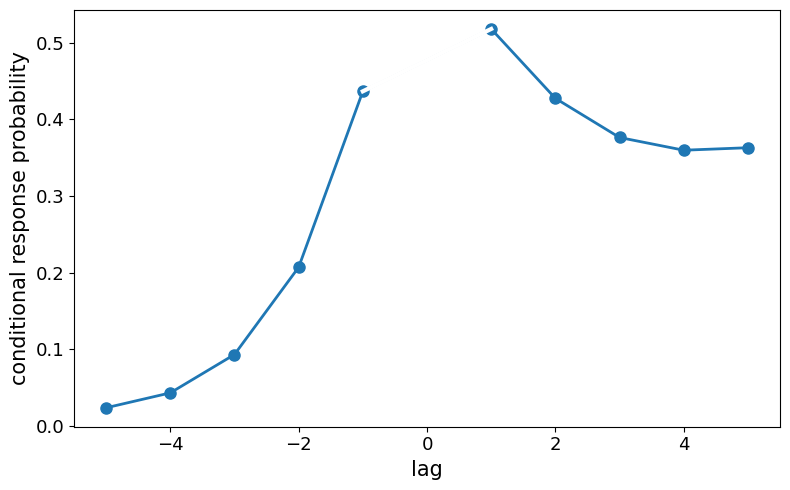

In [15]:
# plot CRP
plt.figure(figsize=(8, 5))
plt.plot(crps['transitions'], crps['crp'], 'o-', linewidth=2, markersize=8)

# Add white segments to mask the gap at lag 0 (between -1 and 1)
mask_indices = (crps['transitions'] == -1) | (crps['transitions'] == 1)
if mask_indices.sum() == 2:
    idx_neg1 = crps[crps['transitions'] == -1].index[0]
    idx_pos1 = crps[crps['transitions'] == 1].index[0]
    plt.plot([-1, 1], [crps.loc[idx_neg1, 'crp'], crps.loc[idx_pos1, 'crp']], 
             'w-', linewidth=3, zorder=10)

plt.xlabel('lag', fontsize=15)
plt.ylabel('conditional response probability', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(False)
plt.tight_layout()
plt.show()

### Interpretation
- **Peak at lag ±1**: strongest tendency to recall adjacent items
- **Asymmetry**: stronger forward (positive lag) than backward
- Probability decreases for distant items
- **Gap at lag 0**: Can't recall the same item twice

> Peaked shape demonstrates that context serves as an effective retrieval cue: items studied in similar temporal contexts are recalled together. 

## Weight Matrices

Learned associations between items and temporal context after encoding.

#### Feature-to-Context ($M^{FC}$)
- **Rows**: Context elements
- **Columns**: Item positions (serial order)
- **Values**: How strongly each item activates each context element
- **Interpretation**: Shows what context was active when each item was encoded

#### Context-to-Feature ($M^{CF}$)
- **Rows**: Item positions
- **Columns**: Context elements  
- **Values**: How strongly each context element retrieves each item
- **Interpretation**: Shows which items are cued by each context state

These matrices implement the episodic memory feedback-loop. 
- During retrieval, current context state activates items via $M^{CF}$,
- Then, retrieved items update context via $M^{FC}$.

In [16]:
# re-organize weight matrices for plotting (so as to view them by serial position)
net_w_fc_inorder = net_w_fc[:, pres_indices - 1]  # convert to 0-indexed
net_w_cf_inorder = net_w_cf[pres_indices - 1, :]  

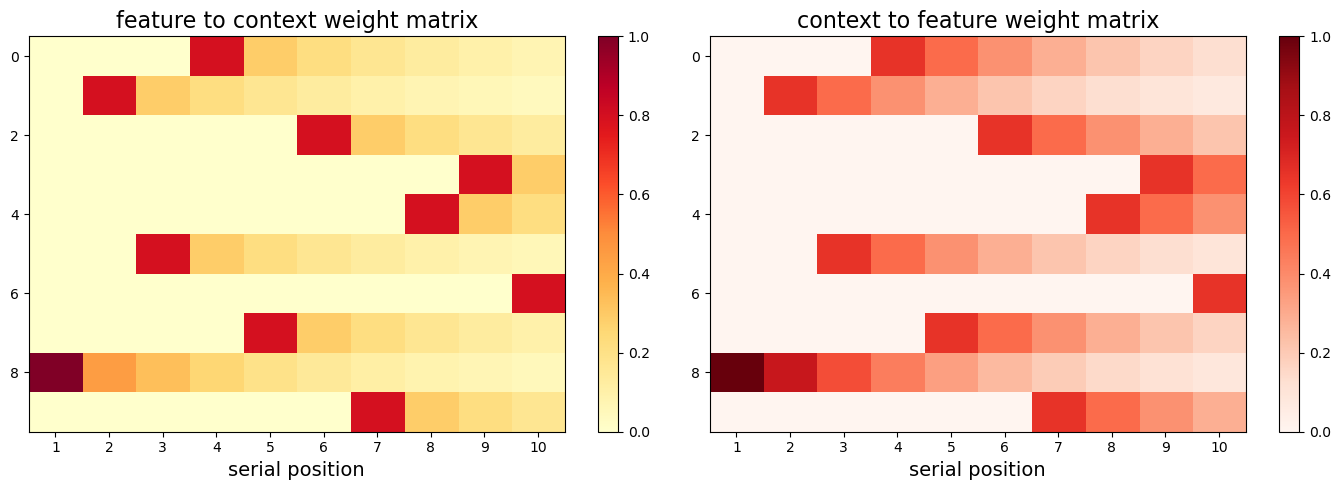

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Feature to context weight matrix
im1 = axes[0].imshow(net_w_fc_inorder, cmap='YlOrRd', aspect='auto')
axes[0].set_title('feature to context weight matrix', fontsize=16)
axes[0].set_xlabel('serial position', fontsize=14)
axes[0].set_ylabel('', fontsize=14)
axes[0].set_xticks(np.arange(len(pres_indices)))
axes[0].set_xticklabels(np.arange(1, len(pres_indices) + 1))
plt.colorbar(im1, ax=axes[0])

# Context to feature weight matrix
im2 = axes[1].imshow(net_w_cf_inorder.T, cmap='Reds', aspect='auto')
axes[1].set_title('context to feature weight matrix', fontsize=16)
axes[1].set_xlabel('serial position', fontsize=14)
axes[1].set_ylabel('', fontsize=14)
axes[1].set_xticks(np.arange(len(pres_indices)))
axes[1].set_xticklabels(np.arange(1, len(pres_indices) + 1))
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

#### Why no diagonal pattern yet:
Reordered **only one axis** (serial-position axis), but left the other axis in the model’s **raw** context-dimension order.

This mixes coordinate systems:
- x-axis: serial position space
- y-axis: raw context-dimension space

#### To reveal the diagonal pattern:
Convert the matrix into **serial-position coordinates** on *both* axes by applying the same permutation to both rows and columns:

$M^{FC}_{\text{serial}} = M^{FC}[\text{perm,perm}]$

$M^{CF}_{\text{serial}} = M^{CF}[\text{perm,perm}]$

where $\text{perm,perm}$ is the permutation that maps internal indices to serial-position order.

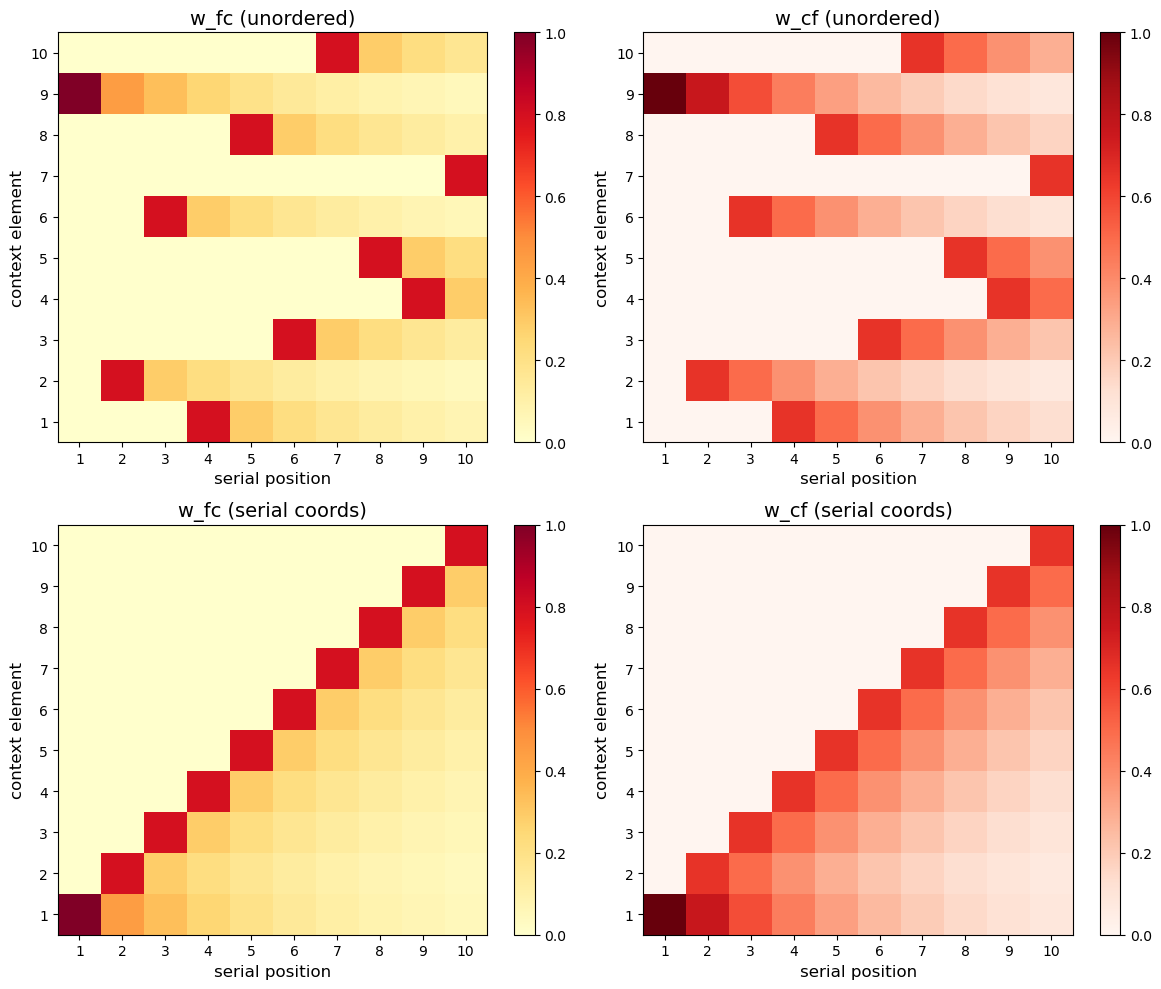

In [18]:
perm = pres_indices - 1
N = len(pres_indices)

net_w_fc_ser = net_w_fc[np.ix_(perm, perm)]
net_w_cf_ser = net_w_cf[np.ix_(perm, perm)]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# --- Unordered ---
im = axes[0,0].imshow(net_w_fc_inorder, cmap='YlOrRd', aspect='auto', origin='lower')
axes[0,0].set_title('w_fc (unordered)', fontsize=14)
plt.colorbar(im, ax=axes[0,0])

im = axes[0,1].imshow(net_w_cf_inorder.T, cmap='Reds', aspect='auto', origin='lower')
axes[0,1].set_title('w_cf (unordered)', fontsize=14)
plt.colorbar(im, ax=axes[0,1])

# --- Serial ---
im = axes[1,0].imshow(net_w_fc_ser, cmap='YlOrRd', aspect='auto', origin='lower')
axes[1,0].set_title('w_fc (serial coords)', fontsize=14)
plt.colorbar(im, ax=axes[1,0])

im = axes[1,1].imshow(net_w_cf_ser.T, cmap='Reds', aspect='auto', origin='lower')
axes[1,1].set_title('w_cf (serial coords)', fontsize=14)
plt.colorbar(im, ax=axes[1,1])

# Label all axes consistently
for ax in axes.ravel():
    ax.set_xticks(np.arange(N))
    ax.set_xticklabels(np.arange(1, N+1))
    ax.set_yticks(np.arange(N))
    ax.set_yticklabels(np.arange(1, N+1))
    ax.set_xlabel('serial position', fontsize=12)
    ax.set_ylabel('context element', fontsize=12)

plt.tight_layout()
plt.show()

- **Diagonal structure**: Items are most strongly associated with their encoding context

- **Gradient/smearing**: Due to context drift, nearby items share similar contexts
    - More smearing = more context overlap = stronger temporal associations
    - Less smearing = more distinct contexts = weaker temporal associations

- **First item distinctiveness**: High initial drift (B=1.0) create unique first-item pattern

## Correlation Matrices

Analyzes the similarity structure of learned representations by computing correlations between columns (items) of the weight matrices. 
> Items with **high context correlation** are likely to be recalled together.

#### Feature-to-Context Correlations
- Correlates context patterns activated by different items
- **High correlation**: Two items activated similar contexts (encoded nearby in time)
- **Low correlation**: Two items activated distinct contexts (encoded far apart)

#### Context-to-Feature Correlations  
- Correlates the retrieval strength patterns across context states
- **High correlation**: Two items are similarly cued by the same contexts
- **Low correlation**: Two items are cued by different contexts

### Correlation plots

1. For **feature-to-context** association matrix `net_w_fc_inorder`:
  $$M^{FC}\quad (\text{context rows} \times \text{item columns})$$

  - Transposing `net_w_fc_inorder.T` correlates **columns** of $M^{FC}$ with each other.  
  - Each column $j$ represents the **context footprint** of item $j$: $$M^{FC}_{:,j} = \text{the context pattern item } j \text{ evokes}$$

  - Therefore, $\text{corr\_fc}[j,k] = \text{similarity}\big(M^{FC}_{:,j},\; M^{FC}_{:,k}\big)$

    > `corr_fc` is an **item–item similarity matrix**, induced by $M^{FC}$.


2. For **context-to-feature** association matrix `net_w_cf_inorder`:
  $$M^{CF}\quad (\text{item rows} \times \text{context columns})$$

  - No transposing correlates **rows** of $M^{CF}$ with each other.  
  - Each row $j$ represents item $j$’s **cueing (readout) profile from context**: $$M^{CF}_{j,:} = \text{“how context cues item } j \text{”}$$

  - Therefore, $\text{corr\_cf}[j,k] = \text{similarity}\big(M^{CF}_{j,:},\; M^{CF}_{k,:}\big)$

    > `corr_cf` is another **item–item similarity matrix**, induced by $M^{CF}$.


#### Weight matrix plots vs. correlation plots

Correlation matrices **remove magnitude information** and retain only **pattern similarity**.  
- Two items can have very different absolute weight magnitudes,
- but still show a high correlation if their *relative* profiles across units are similar.

#### What to expect under temporal contiguity

If nearby serial positions share similar context traces, the item–item correlation matrices should show:
- **Banded diagonal:** strongest correlations near the diagonal (adjacent items)
- **Gradient decay:** correlation decreases as temporal distance increases

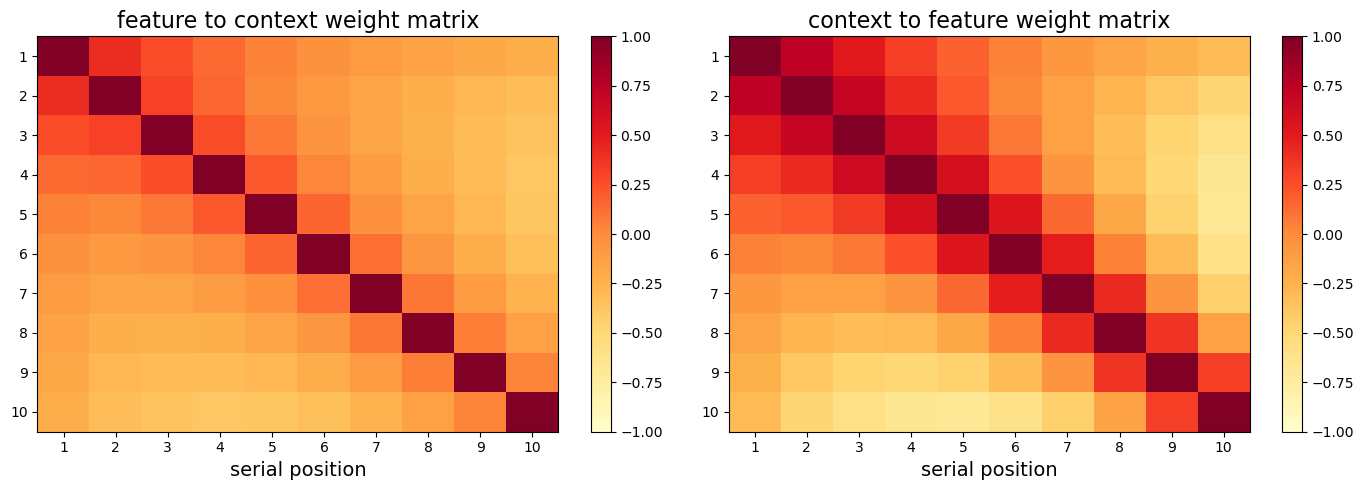

In [19]:
corr_fc = np.corrcoef(net_w_fc_inorder.T)
corr_cf = np.corrcoef(net_w_cf_inorder)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Feature to context correlation matrix
im1 = axes[0].imshow(corr_fc, cmap='YlOrRd', aspect='auto', vmin=-1, vmax=1)
axes[0].set_title('feature to context weight matrix', fontsize=16)
axes[0].set_xlabel('serial position', fontsize=14)
axes[0].set_ylabel('', fontsize=14)
axes[0].set_xticks(np.arange(len(pres_indices)))
axes[0].set_xticklabels(np.arange(1, len(pres_indices) + 1))
axes[0].set_yticks(np.arange(len(pres_indices)))
axes[0].set_yticklabels(np.arange(1, len(pres_indices) + 1))
plt.colorbar(im1, ax=axes[0])

# Context to feature correlation matrix
im2 = axes[1].imshow(corr_cf, cmap='YlOrRd', aspect='auto', vmin=-1, vmax=1)
axes[1].set_title('context to feature weight matrix', fontsize=16)
axes[1].set_xlabel('serial position', fontsize=14)
axes[1].set_ylabel('', fontsize=14)
axes[1].set_xticks(np.arange(len(pres_indices)))
axes[1].set_xticklabels(np.arange(1, len(pres_indices) + 1))
axes[1].set_yticks(np.arange(len(pres_indices)))
axes[1].set_yticklabels(np.arange(1, len(pres_indices) + 1))
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

### Rationale
1. Overall pattern:
   - **Diagonal (perfect correlation)**: Each item correlates perfectly with itself
   - **Near-diagonal bands**: Show temporal neighborhood structure
   - **Off-diagonal patterns**: Reveal long-range associations

2. **Width of diagonal**: temporal resolution of context
   - Narrow band = sharp temporal discrimination
   - Wide band = gradual context change

2. **Asymmetries**: forward/backward association differences

3. **Clustering**: Groups of items with similar correlation profiles

### Interpretation
- Wider diagonal towards the left: early items share more similar contexts because context hasn’t diverged much yet.

- `corr_fc` diagonal thinner than `corr_cf`: because $M^{FC}$ results from weaker learning (`gamma_fc`< 1), while $M^{CF}$ is written strongly (`lrate_cf_enc` = 1).

# Parameter Sweep

## Vary recall drift rate

### Simulation setup

In [20]:
# Sweep values for retrieval drift
B_rec_grid = [0.10, 0.25, 0.40, 0.55, 0.70, 0.85]

# For reproducibility across sweeps (same random seeds per B_rec)
BASE_SEED = 2026

# Useful constants
N = len(pres_indices)
serial_labels = np.arange(1, N + 1)

### Simulation loop

In [31]:
from collections import defaultdict

def _simulate_one_list(B_rec, rng, record_diag=False):
    """
    Simulate ONE list: encoding + recall.
    
    Returns:
      recalls (N,), times (N,), net_w_fc (N,N), net_w_cf (N,N), diag (dict or None)
    """
    # -------------------- INIT --------------------
    net_f = np.zeros((N, 1))
    net_c = np.zeros((N, 1))

    # learning rate matrices (constant scalars expanded)
    net_lrate_fc_enc = np.full((N, N), lrate_fc_enc)
    net_lrate_cf_enc = np.full((N, N), lrate_cf_enc)
    net_lrate_fc_rec = np.full((N, N), lrate_fc_rec)
    net_lrate_cf_rec = np.full((N, N), lrate_cf_rec)

    # associative weight matrices
    net_w_fc = np.eye(N) * eye_fc
    net_w_cf = np.eye(N) * eye_cf

    # -------------------- ENCODING --------------------
    for item in range(N):
        feature_idx = pres_indices[item] - 1  # 0-based item ID

        net_f = np.zeros((N, 1))
        net_f[feature_idx] = 1

        # context input from feature
        net_c_in = net_w_fc @ net_f
        net_c_in = net_c_in / float(np.sqrt(net_c_in.T @ net_c_in))

        # advance context
        c_in, c = net_c_in, net_c
        B = B_encD[item]
        dot = float(c.T @ c_in)
        rho = np.sqrt(1 + (B**2) * ((dot**2) - 1)) - B * dot
        net_c = rho * c + B * c_in

        # update weights
        net_w_fc += (net_c @ net_f.T) * net_lrate_fc_enc
        net_w_cf += (net_f @ net_c.T) * net_lrate_cf_enc

    # -------------------- RECALL SETUP --------------------
    recalls = np.zeros((N, 1))
    times = np.zeros((N, 1))

    retrieved = np.zeros((N, 1), dtype=bool)
    thresholds = np.ones((N, 1))

    # cue matrix (semantic + episodic mixture)
    net_weights = episodic_weight * net_w_cf + sem_weight * sem_mat

    time_passed = 0
    recall_count = 0

    # diagnostic containers (only used if record_diag=True)
    if record_diag:
        deltas_all = []
        deltas_by_pos = defaultdict(list)
        delta_forward = []
        delta_backward = []
        pending = None  # store delta_f to label when next recall happens
    else:
        pending = None

    # -------------------- RECALL LOOP --------------------
    while time_passed < rec_time_local:

        # input evidence from context
        f_in = net_weights @ net_c

        max_cycles = int((rec_time_local - time_passed) / dt)
        dt_tau = dt / tau
        sq_dt_tau = np.sqrt(dt_tau)

        # noise for full interval
        noise = rng.normal(0, eta * sq_dt_tau, size=(N, max_cycles))

        # inhibition matrix
        eyeI = ~np.eye(N, dtype=bool)
        lmat = eyeI.astype(float) * L

        x = np.zeros((N, 1))
        K_array = np.ones((N, 1)) * K
        inds = np.arange(N)

        crossed = 0
        i = 0

        # ---- accumulator cycling ----
        while i < max_cycles and crossed == 0:

            lx = lmat @ x
            kx = K_array * x

            x = x + ((f_in - kx - lx) * dt_tau + noise[:, i:i+1])
            x[x < 0] = 0

            # reset retrieved above threshold
            reset_these = retrieved & (x >= thresholds)
            x[reset_these] = 0.95 * thresholds[reset_these]

            retrievable = ~retrieved

            if np.any(x[retrievable] >= thresholds[retrievable]):
                crossed = 1
                temp_win = x[retrievable] >= thresholds[retrievable]
                temp_ind = inds[retrievable.flatten()]
                winners = temp_ind[temp_win.flatten()]
                if len(winners) > 1:
                    winners = np.array([rng.choice(winners)])

            i += 1

        time_passed += i * dt

        # ---- if someone retrieved ----
        if crossed == 1:
            winner = int(winners[0])

            # serial position of winner (0..N-1), using presentation order
            serial_pos0 = np.where(pres_indices - 1 == winner)[0][0]
            serial_pos1 = serial_pos0 + 1  # 1..N

            # label pending delta_f based on actual transition direction
            if record_diag and pending is not None:
                prev_pos0 = pending["serial_pos0"]
                delta_f_prev = pending["delta_f"]

                transition = serial_pos0 - prev_pos0
                if transition == 1:
                    delta_forward.append(delta_f_prev)
                elif transition == -1:
                    delta_backward.append(delta_f_prev)

                pending = None

            # activate retrieved feature
            net_f = np.zeros((N, 1))
            net_f[winner] = 1

            # update context
            net_c_in = net_w_fc @ net_f
            net_c_in = net_c_in / float(np.sqrt(net_c_in.T @ net_c_in))

            c_in, c = net_c_in, net_c
            dot = float(c.T @ c_in)
            rho = np.sqrt(1 + (B_rec**2) * ((dot**2) - 1)) - B_rec * dot
            net_c = rho * c + B_rec * c_in

            # update weights during recall (usually zero)
            net_w_fc += (net_c @ net_f.T) * net_lrate_fc_rec
            net_w_cf += (net_f @ net_c.T) * net_lrate_cf_rec

            # record recall
            recall_count += 1
            recalls[recall_count - 1, 0] = serial_pos1
            times[recall_count - 1, 0] = time_passed

            # compute delta_f if needed
            if record_diag:
                left_pos0 = serial_pos0 - 1
                right_pos0 = serial_pos0 + 1

                if 0 <= left_pos0 < N and 0 <= right_pos0 < N:
                    left_item = pres_indices[left_pos0] - 1
                    right_item = pres_indices[right_pos0] - 1

                    if (not retrieved[left_item]) and (not retrieved[right_item]):
                        f_after = (net_weights @ net_c).flatten()
                        delta_f = f_after[right_item] - f_after[left_item]

                        deltas_all.append(delta_f)
                        deltas_by_pos[serial_pos1].append(delta_f)

                        pending = {"serial_pos0": serial_pos0, "delta_f": delta_f}

            retrieved[winner] = True

    diag = None
    if record_diag:
        diag = {
            "deltas_all": deltas_all,
            "deltas_by_pos": dict(deltas_by_pos),
            "delta_forward": delta_forward,
            "delta_backward": delta_backward
        }

    return recalls.flatten(), times.flatten(), net_w_fc, net_w_cf, diag

def run_cmr_sem_simulation(B_rec, n_sims=100, seed=2026):
    """
    Runs n_sims independent list simulations.
    Returns EXACTLY the same 4 outputs as before.
    """
    rng = np.random.default_rng(seed)

    recall_sims = np.zeros((N, n_sims), dtype=int)
    times_sims  = np.zeros((N, n_sims), dtype=float)

    net_w_fc_last = None
    net_w_cf_last = None

    for s in range(n_sims):
        recalls, times, net_w_fc, net_w_cf, _ = _simulate_one_list(
            B_rec=B_rec,
            rng=rng,
            record_diag=False
        )
        recall_sims[:, s] = recalls.astype(int)
        times_sims[:, s]  = times

        net_w_fc_last = net_w_fc
        net_w_cf_last = net_w_cf

    return recall_sims, times_sims, net_w_fc_last, net_w_cf_last

### Metric functions

In [22]:
def compute_spc(recall_sims, N):
    """
    Serial position curve: P(position j recalled at least once).
    With repeats prevented, counting occurrences equals counting recall-at-least-once.
    """
    spc = np.zeros(N)
    for j in range(1, N+1):
        spc[j-1] = np.mean(np.any(recall_sims == j, axis=0))
    return spc

def compute_pfr(recall_sims, N):
    """
    Probability of first recall (PFR): P(first output = serial position j).
    """
    first = recall_sims[0, :]
    first = first[first > 0]
    pfr = np.zeros(N)
    if len(first) > 0:
        for j in range(1, N+1):
            pfr[j-1] = np.mean(first == j)
    return pfr

def compute_lag_crp_opportunity_corrected(recall_sims, N):
    """
    True lag-CRP: opportunity-corrected conditional response probability.
    Uses lag = next - current.
    
    recall_sims: (N, n_sims), each column is a recall sequence (serial positions 1..N, 0 = blank)
    """
    max_lag = N - 1
    lag_vals = np.arange(-max_lag, max_lag + 1)

    numer = np.zeros(len(lag_vals), dtype=float)
    denom = np.zeros(len(lag_vals), dtype=float)

    lag_to_idx = {L: i for i, L in enumerate(lag_vals)}

    for s in range(recall_sims.shape[1]):
        seq = recall_sims[:, s]
        seq = seq[seq > 0].astype(int)

        if len(seq) < 2:
            continue

        recalled = set()

        for t in range(len(seq) - 1):
            cur = seq[t]
            nxt = seq[t + 1]

            recalled.add(cur)
            remaining = [j for j in range(1, N + 1) if j not in recalled]

            # Opportunity counts: all possible lags from cur to remaining items
            for j in remaining:
                L = j - cur
                denom[lag_to_idx[L]] += 1

            # Actual transition lag
            L_obs = nxt - cur
            numer[lag_to_idx[L_obs]] += 1

    crp = np.zeros_like(numer)
    valid = denom > 0
    crp[valid] = numer[valid] / denom[valid]

    return lag_vals, crp

def neighbor_advantage_diagnostics(B_rec, n_sims=100, seed=2026):
    """
    Returns EXACTLY the same dict structure as before:
      - deltas_all
      - deltas_by_pos
      - delta_forward
      - delta_backward
    """
    rng = np.random.default_rng(seed)

    deltas_all = []
    deltas_by_pos = defaultdict(list)
    delta_forward = []
    delta_backward = []

    for s in range(n_sims):
        _, _, _, _, diag = _simulate_one_list(
            B_rec=B_rec,
            rng=rng,
            record_diag=True
        )

        deltas_all.extend(diag["deltas_all"])
        delta_forward.extend(diag["delta_forward"])
        delta_backward.extend(diag["delta_backward"])

        for k, v in diag["deltas_by_pos"].items():
            deltas_by_pos[k].extend(v)

    return {
        "deltas_all": deltas_all,
        "deltas_by_pos": dict(deltas_by_pos),
        "delta_forward": delta_forward,
        "delta_backward": delta_backward
    }

### Run the sweep

In [32]:
sweep_results = {}

for idx, B_rec_val in enumerate(B_rec_grid):
    seed = BASE_SEED + idx

    recall_sims, times_sims, net_w_fc, net_w_cf = run_cmr_sem_simulation(
        B_rec=B_rec_val,
        n_sims=n_sims,
        seed=seed
    )

    spc = compute_spc(recall_sims, N)
    pfr = compute_pfr(recall_sims, N)
    lag_vals, lag_probs = compute_lag_crp_opportunity_corrected(recall_sims, N)
    diag = neighbor_advantage_diagnostics(B_rec_val, n_sims=n_sims, seed=seed)

    sweep_results[B_rec_val] = {
        "recall_sims": recall_sims,
        "times_sims": times_sims,
        "SPC": spc,
        "PFR": pfr,
        "lag_vals": lag_vals,
        "lag_probs": lag_probs,
        "net_w_fc": net_w_fc,
        "net_w_cf": net_w_cf,
        "cue_diag": diag
    }

### SPC curves

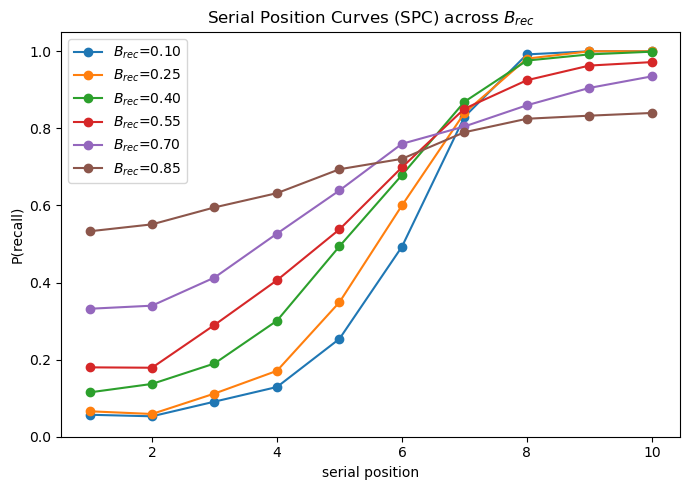

In [24]:
plt.figure(figsize=(7,5))

for B_rec_val in B_rec_grid:
    spc = sweep_results[B_rec_val]["SPC"]
    plt.plot(serial_labels, spc, marker="o", label=f"$B_{{rec}}$={B_rec_val:.2f}")

plt.title("Serial Position Curves (SPC) across $B_{rec}$")
plt.xlabel("serial position")
plt.ylabel("P(recall)")
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.show()

### PFR curves

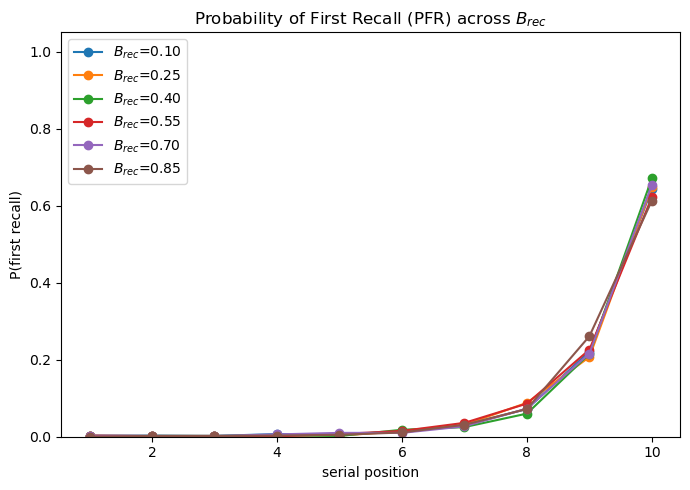

In [25]:
plt.figure(figsize=(7,5))

for B_rec_val in B_rec_grid:
    pfr = sweep_results[B_rec_val]["PFR"]
    plt.plot(serial_labels, pfr, marker="o", label=f"$B_{{rec}}$={B_rec_val:.2f}")

plt.title("Probability of First Recall (PFR) across $B_{rec}$")
plt.xlabel("serial position")
plt.ylabel("P(first recall)")
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.show()

### lag-CRP (conditional response probabilities)

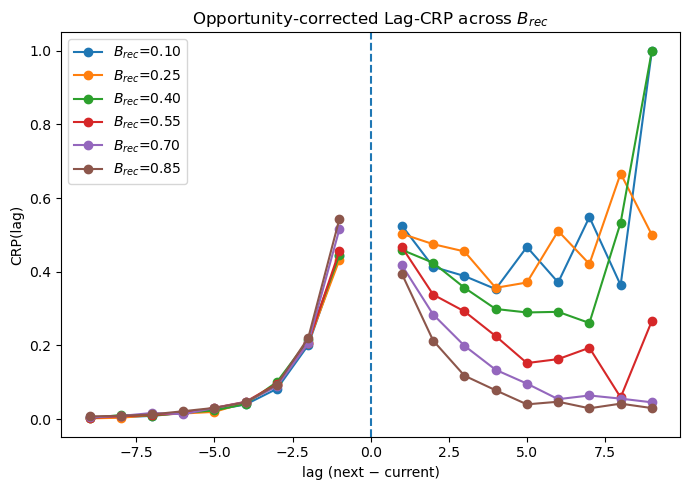

In [26]:
plt.figure(figsize=(7,5))

for B_rec_val in B_rec_grid:
    recall_sims = sweep_results[B_rec_val]["recall_sims"]
    lag_vals, crp = compute_lag_crp_opportunity_corrected(recall_sims, N)

    neg = lag_vals < 0
    pos = lag_vals > 0

    # plot negative part first, and capture its color
    line_neg, = plt.plot(
        lag_vals[neg], crp[neg],
        marker="o",
        label=f"$B_{{rec}}$={B_rec_val:.2f}"
    )
    color = line_neg.get_color()

    # plot positive part using the SAME color
    plt.plot(
        lag_vals[pos], crp[pos],
        marker="o",
        color=color
    )

plt.axvline(0, linestyle="--")
plt.title("Opportunity-corrected Lag-CRP across $B_{rec}$")
plt.xlabel("lag (next − current)")
plt.ylabel("CRP(lag)")
plt.legend()
plt.tight_layout()
plt.show()

### Cue advantage for each serial position
> When the model has just recalled position $i$ and both neighbors $(i-1,\; i+1)$ are still recallable, does the cue favor moving **forward** to $i+1$ or **backward** to $i-1$? How does this neighbor bias vary with the current serial position $i$?

At a moment of recall, compute the current cue/input to each item:

$$
f_{\text{after}} = (w_{\text{epi}} M^{CF} + w_{\text{sem}} M_{\text{sem}})\, c
$$

Then measure the local neighbor cue advantage at serial position $i$:

$$
\Delta f(i) = f(i+1) - f(i-1)
$$

- $\Delta f(i) > 0$: the current context cue favors moving **forward** to $i+1$ more than backward to $i-1$
- $\Delta f(i) \approx 0$: forward and backward neighbors are **equally cued**
- $\Delta f(i) < 0$: the cue favors moving **backward** to $i-1$

#### How mean is computed for each serial position: stratified, not event-weighted across $i$

For each serial position $i$, record $\Delta f(i)$ **only on recall events where both neighbors are available**.  
Then average **within that position**:

$$
\overline{\Delta f}(i)=\frac{1}{n_i}\sum_{k=1}^{n_i}\Delta f_k(i)
$$

Here $n_i$ is the number of valid events observed at position $i$.  
**Each $i$ gets its own mean** (rare positions do *not* get “down-weighted” by frequent positions, because they are not pooled together).

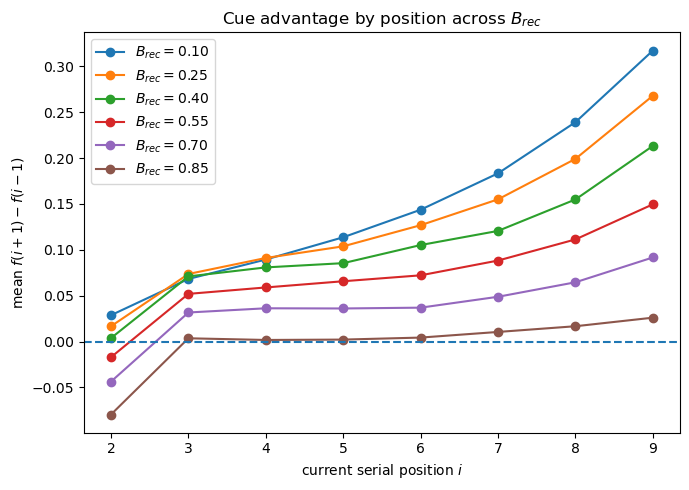

In [33]:
plt.figure(figsize=(7,5))

positions = np.arange(1, N+1)

for B_rec_val in B_rec_grid:
    diag = sweep_results[B_rec_val]["cue_diag"]   # reuse saved diagnostics
    
    means = []
    for p in positions:
        vals = diag["deltas_by_pos"].get(p, [])
        means.append(np.mean(vals) if len(vals) > 0 else np.nan)
    
    plt.plot(positions, means, marker="o", label=rf"$B_{{rec}}={B_rec_val:.2f}$")

plt.axhline(0, linestyle="--")
plt.title("Cue advantage by position across $B_{rec}$")
plt.xlabel("current serial position $i$")
plt.ylabel(r"mean $f(i+1)-f(i-1)$")
plt.legend()
plt.tight_layout()
plt.show()

### Cue advantage for each $B_{rec}$
> Under the same “both-neighbors-available” condition, what is the model’s **overall** neighbor cue bias (forward vs. backward) when retrieval drift $B_{rec}$ changes?

At a moment of recall, compute the current cue/input to each item:

$$
f_{\text{after}} = (w_{\text{epi}} M^{CF} + w_{\text{sem}} M_{\text{sem}})\, c
$$

Then measure the local neighbor cue advantage at serial position $i$:

$$
\Delta f(i) = f(i+1) - f(i-1)
$$

#### How mean is computed for each parameter value: pooled, event-weighted across $i$

For a fixed parameter value (e.g., a given $B_{rec}$), pool **all** valid neighbor-available events across **all** positions $i$, then take one grand mean:

$$
\overline{\Delta f}=\frac{1}{K}\sum_{k=1}^{K}\Delta f_k
$$

where $K$ is the total number of valid events pooled across positions.

This is a **frequency-weighted** average of the position-wise means:

$$
\overline{\Delta f}=\sum_i \frac{n_i}{K}\,\overline{\Delta f}(i)
$$

So positions with more valid events (larger $n_i$) contribute more to $\overline{\Delta f}$.

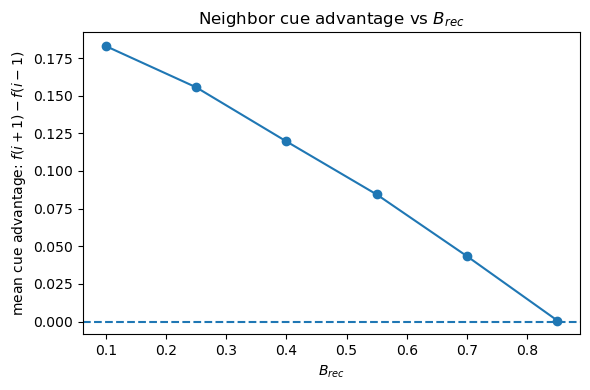

In [34]:
adv = []

for B_rec_val in B_rec_grid:
    diag = sweep_results[B_rec_val]["cue_diag"]   # reuse saved diagnostics
    adv.append(np.mean(diag["deltas_all"]) if len(diag["deltas_all"]) > 0 else np.nan)

plt.figure(figsize=(6,4))
plt.plot(B_rec_grid, adv, marker="o")
plt.axhline(0, linestyle="--")
plt.title("Neighbor cue advantage vs $B_{rec}$")
plt.xlabel("$B_{rec}$")
plt.ylabel(r"mean cue advantage: $f(i+1) - f(i-1)$")
plt.tight_layout()
plt.show()